<a href="https://doi.org/10.5194/gmd-13-3863-2020"><img style="float: center; width: 100%" src="../media/HyLands_Logo_Header.png"></a>

# Bedrock landslides on existing topography (SRTM DEM)
This notebook provides a brief introduction and user's guide for the BedrockLandslider component for landscape evolution modeling. It combines two documents, a User's Manual and a notebook-based example, written Benjamin Campforts to accompany the following publication:

* Campforts et al. 2021, in review
* Campforts B., Shobe C.M., Steer P., Vanmaercke M., Lague D., Braun J. (2020) HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution. Geosci Model Dev: 13(9):3863–86. 

First we will import all the modules we need. 

In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask
from landlab import imshowhs_grid, imshow_grid
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab import RasterModelGrid

from bmi_topography import Topography

## 1. Download SRTM image using the bmi-topography package
### bmi-topography
The bmi-topography package is a data component, recently developed by coding wizard Mark Piper. For more information on how to install an use it on your own machine, check out the [bmi-topography repo](https://github.com/csdms/bmi-topography) and this [notebook on bmi-topography](https://github.com/csdms/bmi-topography/blob/main/examples/topography.ipynb).

Bmi-topography is a Python library for fetching and caching NASA Shuttle Radar Topography Mission (SRTM) land elevation data using the [OpenTopography](https://opentopography.org/) [REST ](https://portal.opentopography.org/apidocs/) [API](https://www.mulesoft.com/resources/api/what-is-an-api).

The bmi-topography library provides access to the following global raster datasets:

    SRTM GL3 (90m)
    SRTM GL1 (30m)
    SRTM GL1 (Ellipsoidal)

The library includes an API and a CLI that accept the dataset type, a latitude-longitude bounding box, and the output file format. Data are downloaded from OpenTopography and cached locally. The cache is checked before downloading new data. 

The bmi-topography API is wrapped with a [Basic Model Interface (BMI)](https://bmi.readthedocs.io/), which provides a standard set of functions for coupling with data or models that also expose a BMI. More information on the BMI can found in its [documentation](https://bmi.readthedocs.io/).


### download some data

Create an instance of `Topography` using parameters to describe

* the type of data requested,
* the geographic bounding box of the data,
* the file format (we want to save it as an ascii file), and 
* where to store the file

with the following step:


In [2]:
topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

/Users/beca4397/opt/anaconda3/envs/landlab_dev/lib/python3.10/site-packages/bmi_topography/topography.py:26: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


While this step sets up a call to the OpenTopography API, it doesn't download the data. Download the data by calling the `fetch` method :

In [3]:
fname = topo.fetch()
print(fname)

/Users/beca4397/Google_Drive/ESPIn/ESPIn2022/ivy/lessons/landlab/landlab/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc


This step may take a few moments to run while the data are fetched from OpenTopography and downloaded.

The `fetch` method only downloads data; it doesn't load it into memory. Call the `load` method to open the downloaded  file and load it into an `xarray` DataArray:

In [4]:
dem = topo.load()
print(dem)

<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)>
array([[[2052, 2050, ..., 1642, 1641],
        [2062, 2056, ..., 1642, 1641],
        ..., 
        [2184, 2182, ..., 1771, 1772],
        [2185, 2185, ..., 1773, 1775]]], dtype=int32)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
  * x        (x) float64 -105.3 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
Attributes:
    transform:   (0.000277777778, 0.0, -105.330138888879, 0.0, -0.00027777777...
    res:         (0.000277777778, 0.000277777778)
    is_tiled:    0
    nodatavals:  (-32768.0,)
    scales:      (1.0,)
    offsets:     (0.0,)
    units:       meters
    location:    node


Note that `load` calls `fetch`, so the latter can be omitted if the goal is the get the data into memory.

## Visualize

Finally, let's visualize the downloaded elevation data.

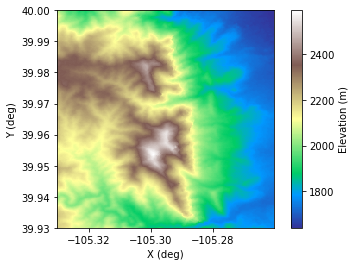

In [5]:
# Read DEM as Lanlab grid
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
#Show dem
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation',cmap =cmap,
            grid_units=("deg", "deg"),colorbar_label="Elevation (m)")
plt.show()

Yup, this is 
<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>


![Boulder](../media/Boulder.jpg)

## 2. Reproject from geographic coordinate system into projected coordinate system

The DEM file is in ESRI Ascii format, but is in a geographic projection, with horizontal units of decimal degrees. To calculate slope gradients properly, we'll first read the DEM into a Landlab grid object that has this geographic projection. Then we'll create a second grid with 30 m cell spacing (approximately equal to the SRTM's resolution), and copy the elevation field from the geographic DEM. This isn't a proper projection of course, but it will do for purposes of this example.

In [6]:
# read the DEM
grid = RasterModelGrid(
    (grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), xy_spacing=30.0
)
grid.add_field("topographic__elevation", elev, at="node")

array([ 2185.,  2185.,  2185., ...,  1643.,  1642.,  1641.])

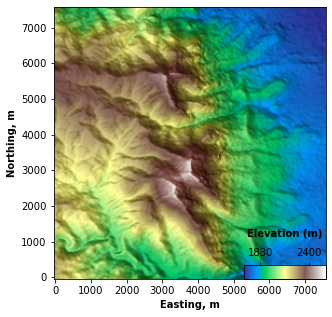

In [7]:
plt.figure(figsize=(5,5))
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshowhs_grid(grid, 'topographic__elevation',cmap =cmap,
            grid_units=("m", "m"),var_name="Elevation (m)", colorbar_label_y = -50)
plt.show()

In [8]:
def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        cmap = copy.copy(mpl.cm.get_cmap("terrain"))
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap=cmap,
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

    if hill_DA:
        # Plot second instance of drainage_area (hill_drainage_area)
        grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plotDA = np.log10(grid.at_node["hill_drainage_area"] * 111e3 * 111e3)
        # plt.figure()
        # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

        plt.figure()
        plot_type = "Drape1"
        # plot_type='Drape2'
        drape1 = np.log10(grid.at_node["hill_drainage_area"])
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=10,
            cbar_tick_size=10,
            var_name="$log^{10} DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = hill_flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

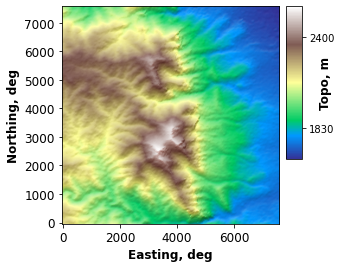

In [9]:
# Plot output products
plotting(grid,DA =False)

### Priority flood flow director/accumulator 
Calculate flow directions/flow accumulation using the first instance of the flow accumulator 

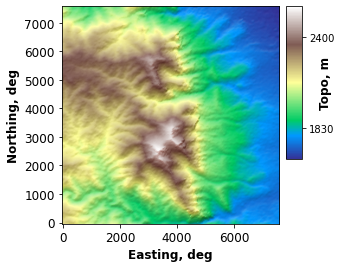

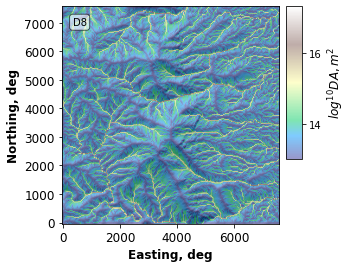

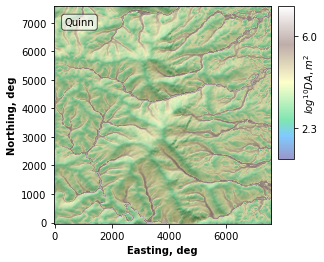

In [10]:
# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

fa_PF.run_one_step()

# Plot output products
plotting(grid, hill_DA=True)

### Instantiate landslider

In [11]:
_ = grid.add_zeros('soil__depth',at='node')

In [12]:
ls = BedrockLandslider(
    grid, 
    angle_int_frict=.5,
    landslides_return_time=1e3,
    cohesion_eff = 1e3,)
ls.run_one_step(dt=50)

/Users/beca4397/Google_Drive/landlab/landlab/components/bedrock_landslider/bedrock_landslider.py:647: RuntimeWarning: divide by zero encountered in true_divide
  self.grid.dx / (1 - (slope / self._angle_int_frict) ** 2),


(0.0, 6814319.6924301051)

## Visualization of results
### Magnitude frequency of landslides simulated over 200 years

Text(0, 0.5, 'Landslide frequency')

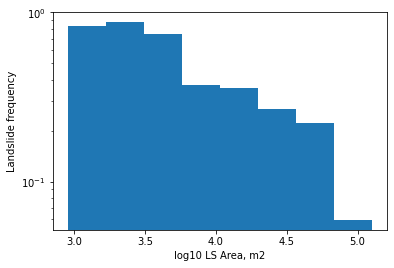

In [13]:
plt.figure()
LS_size = np.array(ls.landslides_size) * grid.dx ** 2
counts, bins = np.histogram(np.log10(LS_size), 8)
plt.hist(np.log10(LS_size), log=True, bins=bins, density=True)
# counts, bins = np.histogram(LS_size, 10)
# plt.hist(LS_size, bins=bins)
plt.xlabel("log10 LS Area, m2")
plt.ylabel("Landslide frequency")

### Location of landslides during last model iteration

Let's plot the resulting landslides 

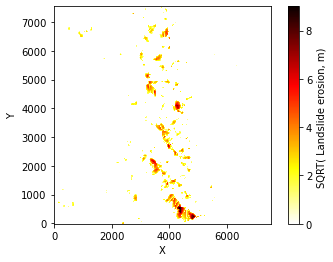

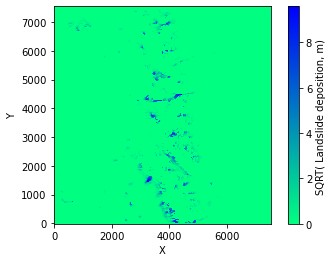

In [14]:
# Landslide Erosion 
cmap = copy.copy(mpl.cm.get_cmap("hot_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__erosion"]), colorbar_label = 'SQRT( Landslide erosion, m) ',cmap =cmap)
plt.show()

# Landslide Deposition 
cmap = copy.copy(mpl.cm.get_cmap("winter_r"))
imshow_grid(grid,np.sqrt(grid.at_node["landslide__deposition"]), colorbar_label = 'SQRT( Landslide deposition, m) ',cmap =cmap)
plt.show()


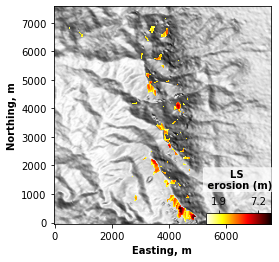

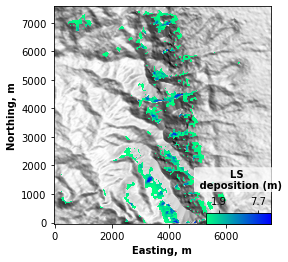

In [15]:
# Show Landslide Erosion draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
imshowhs_grid(
    grid,
    "topographic__elevation",
    drape1=np.sqrt(grid.at_node["landslide__erosion"]),
    plot_type="Drape1",
    var_name="LS \n erosion",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap1,
    ticks_km=False,
    colorbar_label_y=-55,
    add_label_bbox=True,
    thres_drape1=.01,
)
plt.show()
# Show Landslide deposition draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("winter_r"))
imshowhs_grid(
    grid,
    "topographic__elevation",
    drape1=np.sqrt(grid.at_node["landslide__deposition"]),
    plot_type="Drape1",
    var_name="LS \n deposition",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap1,
    ticks_km=False,
    colorbar_label_y=-55,
    add_label_bbox=True,
    thres_drape1=0.01,
)
plt.show()



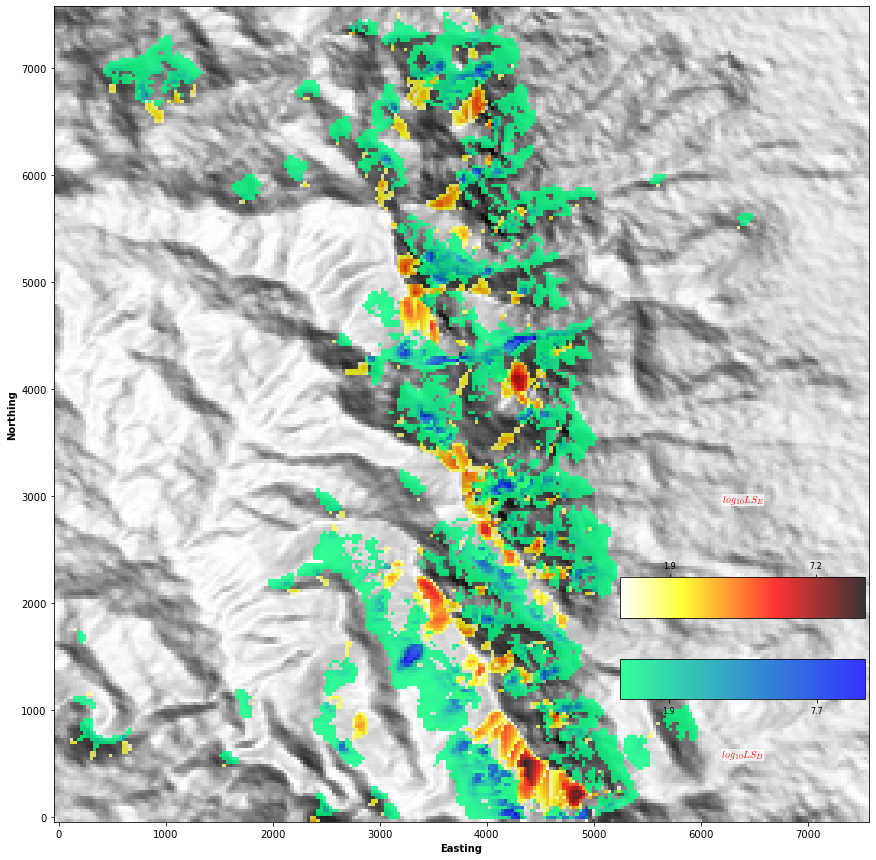

In [16]:
# Show Landslide erosion and deposition draped over the shaded topographic relief
cmap1 = copy.copy(mpl.cm.get_cmap("Blues"))
thres_drape1=0.01
thres_drape2=0.01
alpha  = .8
alpha2 = .8
drape1 = np.sqrt(grid.at_node["landslide__erosion"])
drape2 = np.sqrt(grid.at_node["landslide__deposition"])
cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
cmap2 = copy.copy(mpl.cm.get_cmap("winter_r"))
plt.figure(figsize=(15,15))
imshowhs_grid(grid, "topographic__elevation",
              plot_type='Drape2',
              var_name='${log_{10}LS_{E}}$', 
              var_name_two= "$log_{10}LS_{D}$",          
              drape1 = drape1,
              cmap=cmap1,
              thres_drape1=thres_drape1,
              alpha=alpha,
              drape2 = drape2,
              cmap2=cmap2,
              thres_drape2=thres_drape2,
              alpha2=alpha2,
              add_double_colorbar=True, 
              cbar_tick_size =8,
              cbar_label_color='red',
              cbar_label_fontweight = 'normal',
              add_label_bbox = True, )
                
plt.show()

## Back to HyLands tutorial page
[Click here to go back to the tutorial overview page](../index.ipynb)